In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
import gym

env = gym.make('LunarLander-v2')

C:\ProgramData\Anaconda3\envs\hands\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [3]:
env.observation_space

Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)

In [4]:
env.seed(42)
obs = env.reset()
obs

array([-0.00499964,  1.4194578 , -0.506422  ,  0.37943238,  0.00580009,
        0.11471219,  0.        ,  0.        ], dtype=float32)

In [5]:
env.action_space

Discrete(4)

In [6]:
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

In [7]:
model = keras.models.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=[n_inputs]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(n_outputs, activation='softmax'),
])

In [8]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(action[0, 0].numpy())
    return obs, reward, done, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = lander_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [9]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [10]:
n_iterations = 100
n_episodes_per_update = 16
n_max_steps = 1000
discount_rate = 0.99

In [11]:
optimizer = keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

In [12]:
env.seed(42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print(f'\rIteration: {iteration + 1}/{ n_iterations}, mean reward: {mean_reward:.1f}', end='')
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 100/100, mean reward: 33.32

In [13]:
env.close()

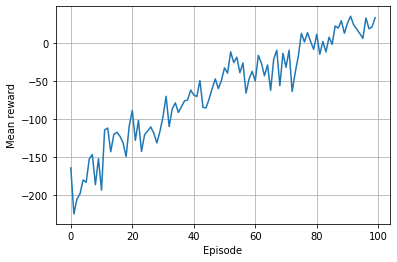

In [14]:
plt.plot(mean_rewards)
plt.xlabel('Episode')
plt.ylabel('Mean reward')
plt.grid()
plt.show()

In [15]:
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch), 
        frames=len(frames), repeat=repeat, interval=interval,
    )
    plt.close()
    return anim

In [16]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make('LunarLander-v2')
    env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode='rgb_array'))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0, 0].numpy())
        if done:
            break
    env.close()
    return frames

In [17]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

C:\ProgramData\Anaconda3\envs\hands\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))
